<a href="https://colab.research.google.com/github/JamesHorrex/SS_AI_TI/blob/master/SS_AITrader_KO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.2.0


In [3]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-u1gg8kd7
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-u1gg8kd7
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.087622f0d4888b557639c605c04a0e822874df5ba_-cp36-none-any.whl size=123835 sha256=6bd4575d9ab5558f18a03de08bb32ffe50026b9f6c5c612e189fbdd90ce56612
  Stored in directory: /tmp/pip-ephem-wheel-cache-boryl4mq/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [5]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [413]:
import pandas as pd 
stock='KO'
df=pd.read_csv('gdrive/My Drive/SS_AITrader/'+stock+'/df_'+stock+'_20drtn_features.csv')

In [414]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
0,2008-03-06,56.999411,44.683477,57.867053,42.771779,-43.377522,-43.377522,-45.016117,-71.318700,62.664428,46.321955,50.773485,37.804351,-0.971853,0.135544,-0.605450,1.914118,2.408594,0.005222,-0.081647,-0.106180,-0.053389,-0.072288,-0.072288,-0.072288,-0.072288,49.399669,36.536587,65.498069,56.684123,-17.485650,-30.523814,0.096383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.161427,0.011966,0.154366,-0.020507,0.224489,-0.003948,27.549999,2.949999,4.019999,-3.975630e+05,-3.975630e+05,-3.975630e+05,-3.975630e+05,0.248114,0.123849,0.056307,-0.012115,-0.094295,2.257,0.044,0.397,-0.480003,-0.720001,1.0
1,2008-03-07,57.264763,46.423004,55.349022,41.908603,-69.955233,-51.655667,-53.054701,-74.065954,61.234965,47.560680,45.083030,34.286592,-0.423012,-0.875864,0.667122,1.012702,0.684342,0.009040,-0.073007,-0.100756,-0.054252,-0.077842,-0.077842,-0.077842,-0.077842,-71.456467,-52.012796,8.839024,4.816483,-15.126372,-27.073891,0.388887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.163399,0.006362,0.149170,-0.020752,0.212239,-0.019587,27.490000,-0.059999,0.949999,-1.028900e+06,-1.028900e+06,-1.028900e+06,-1.028900e+06,0.142281,0.187595,0.016739,-0.055877,0.258830,2.141,-0.116,0.392,0.029999,-0.680000,1.0
2,2008-03-10,53.358296,50.674938,51.002000,38.057589,-78.475352,-57.947011,-59.163980,-75.590560,50.747916,47.890782,39.635853,31.162724,-0.322852,-1.709116,-0.609964,-0.187171,-0.995781,0.006878,-0.066631,-0.096080,-0.055077,-0.088884,-0.088884,-0.088884,-0.088884,-86.345380,-65.912543,1.055134,2.516549,-14.242739,-24.734704,0.014490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.158594,-0.005131,0.141023,-0.031809,0.211490,-0.020060,29.379999,1.889999,3.099998,-1.284733e+06,-1.284733e+06,-1.284733e+06,-1.284733e+06,0.001363,0.044109,-0.014909,-0.108568,0.031474,2.138,-0.003,0.239,-0.040001,-0.709999,1.0
3,2008-03-11,56.572385,54.929855,51.310200,39.250685,-42.152413,-31.125778,-33.118925,-62.889148,54.304095,56.995987,45.873516,34.765675,1.380841,0.626062,0.168439,-0.084004,-0.050418,0.009841,-0.059253,-0.090827,-0.055702,-0.064215,-0.064215,-0.064215,-0.064215,36.231995,24.940602,58.071230,57.194819,-12.525218,-21.418778,0.740742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.161047,0.009512,0.149120,-0.020351,0.205668,-0.026428,26.360001,-3.019999,0.840000,3.171405e+06,3.171405e+06,3.171405e+06,3.171405e+06,-0.001981,0.146940,0.003728,-0.067262,0.577833,2.156,0.018,0.172,0.290001,-0.380005,1.0
4,2008-03-12,46.705842,57.259156,48.380315,41.412081,-47.938194,-40.397385,-41.176522,-64.980563,42.667356,55.283091,39.616788,34.855835,-0.470830,0.577740,-0.821048,-1.432141,-1.218290,0.012439,-0.052324,-0.085604,-0.056199,-0.055324,-0.055324,-0.055324,-0.055324,27.620393,16.915638,31.419265,36.166841,-12.199692,-19.329816,0.433959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.154237,0.001946,0.147592,-0.001793,0.204179,-0.019810,27.219999,0.859999,2.619999,1.059538e+06,1.059538e+06,1.059538e+06,1.059538e+06,-0.057131,0.084058,0.018906,-0.082044,-0.242491,2.043,-0.113,-0.170,-0.879997,-1.080002,1.0


In [415]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [416]:
from_date='2010-01-01'
to_date='2020-01-01'

In [417]:
df = df[pd.to_datetime(from_date) < df['timestamp'] ]
df = df[pd.to_datetime(to_date) > df['timestamp'] ]


In [418]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
445,2010-01-05,35.439594,27.650944,42.943684,59.326550,-88.524652,-93.655619,-93.655619,-54.964586,42.258928,28.662238,47.285138,58.288211,-1.209682,-2.305828,-1.897633,-1.001405,-1.982959,-0.040934,0.059381,0.117432,0.167536,0.005716,0.005716,0.005716,0.005716,-132.429915,-234.383167,-127.070989,-150.515622,10.895964,18.607671,0.247057,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.096808,-0.040975,0.134538,-0.004875,0.136300,-0.008145,19.350000,-0.690001,-0.580000,-3.126621e+06,-3.126621e+06,-3.126621e+06,-3.126621e+06,-0.182901,-0.249137,0.014153,0.142840,0.670637,3.695,-0.091,-0.092,0.090004,-0.009995,0.0
446,2010-01-06,37.193771,19.377235,41.124888,56.732091,-82.411960,-89.130368,-89.913482,-59.090860,28.829212,21.153753,42.253712,56.093641,-0.035487,-1.175435,-2.441981,-1.486531,-2.661132,-0.060824,0.044009,0.106310,0.164879,-0.032526,-0.032526,-0.032526,-0.032526,-101.110438,-178.166517,-160.559644,-169.182090,5.729479,13.252740,0.760876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.091927,-0.051629,0.131575,-0.008946,0.136323,-0.002395,19.160000,-0.190001,-0.850000,-2.148618e+06,-2.148618e+06,-2.148618e+06,-2.148618e+06,-0.069050,-0.165018,0.010732,0.140613,-0.168640,3.763,0.068,0.049,-0.130005,-0.340004,0.0
447,2010-01-07,27.204052,19.047674,36.623851,55.897018,-80.180253,-87.246419,-88.108148,-77.619084,18.791815,21.408530,42.908541,53.861446,-0.248541,-1.490186,-2.583221,-1.885807,-2.583221,-0.081204,0.028096,0.094637,0.161927,-0.067702,-0.067702,-0.067702,-0.067702,-84.520772,-136.641924,-167.709130,-170.472283,1.080005,8.064038,0.709676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090395,-0.052648,0.131447,0.002360,0.129048,-0.009100,19.059999,-0.100000,-0.900000,-1.741227e+06,-1.741227e+06,-1.741227e+06,-1.741227e+06,0.002248,-0.158128,-0.016450,0.122796,-0.313009,3.777,0.014,0.033,0.420006,0.000000,0.0
448,2010-01-08,15.665581,15.076439,32.062272,48.766437,-87.577597,-88.636322,-91.489331,-91.489331,16.544916,20.733793,36.438583,50.703324,-1.850858,-2.129542,-3.245611,-3.735380,-4.634273,-0.110479,0.008904,0.081193,0.158502,-0.135970,-0.135970,-0.135970,-0.135970,-150.319087,-165.213876,-224.539225,-241.613738,-5.097107,1.361006,0.449440,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.121535,-0.023165,0.143954,0.008652,0.136573,-0.001959,18.129999,-0.930000,-3.550001,-6.137620e+06,-6.137620e+06,-6.137620e+06,-6.137620e+06,-0.032127,-0.091245,-0.076368,0.112038,1.169495,3.768,-0.009,-0.025,-0.440002,-0.389999,0.0
449,2010-01-11,39.740323,33.279513,40.823679,51.602485,-52.795035,-52.795035,-67.659570,-67.659570,27.931985,32.024168,35.812836,51.663252,2.030823,-0.106518,-1.349931,-2.036905,-3.943328,-0.129771,-0.007862,0.068422,0.154918,-0.143236,-0.143236,-0.143236,-0.143236,-23.980787,-78.921540,-114.117183,-150.717494,-9.106083,-3.078436,0.890909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.170260,0.095589,0.156141,0.027317,0.145326,0.007411,17.549999,-0.580000,-2.490002,1.254830e+06,1.254830e+06,1.254830e+06,1.254830e+06,0.083800,0.098416,-0.041299,0.131674,-0.002438,3.793,0.025,0.007,-0.470001,-0.529999,0.0


In [419]:
df.drop(['timestamp'], inplace=True, axis=1)

In [420]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

In [421]:
train_labels = train_dataset.pop('labels')
test_labels = test_dataset.pop('labels')

In [422]:
train_labels.head()

1856    1.0
2747    1.0
898     0.0
765     1.0
1100    0.0
Name: labels, dtype: float64

In [423]:
from sklearn.utils import compute_class_weight
def get_sample_weights(y):
      y = y.astype(int)  # compute_class_weight needs int labels
      class_weights = compute_class_weight('balanced', np.unique(y), y)

      print("real class weights are {}".format(class_weights), np.unique(y))
      print("value_counts", np.unique(y, return_counts=True))
      sample_weights = y.copy().astype(float)
      for i in np.unique(y):
          sample_weights[sample_weights == i] = class_weights[i]  # if i == 2 else 0.8 * class_weights[i]
            # sample_weights = np.where(sample_weights == i, class_weights[int(i)], y_)

      return sample_weights


In [424]:
get_sample_weights(train_labels)

real class weights are [1.21437423 0.84995663] [0 1]
value_counts (array([0, 1]), array([ 807, 1153]))


1856    0.849957
2747    0.849957
898     1.214374
765     0.849957
1100    1.214374
          ...   
2051    1.214374
1301    0.849957
2192    0.849957
1640    1.214374
2882    0.849957
Name: labels, Length: 1960, dtype: float64

In [425]:
SAMPLE_WEIGHT=get_sample_weights(train_labels)

real class weights are [1.21437423 0.84995663] [0 1]
value_counts (array([0, 1]), array([ 807, 1153]))


In [426]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

In [427]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [428]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from operator import itemgetter

k=20
list_features = list(normed_train_data.columns)
select_k_best = SelectKBest(f_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)

selected_features_anova

('rsi_10',
 'rsi_15',
 'rsi_20',
 'wr_10',
 'wr_15',
 'wr_20',
 'wr_40',
 'roc_5',
 'roc_10',
 'roc_20',
 'trix_10',
 'macd10',
 'macd15',
 'macd20',
 'macd40',
 'cci_15',
 'cci_25',
 'bb_l20',
 'bb_l40',
 'cmf_10')

In [429]:
select_k_best = SelectKBest(mutual_info_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
selected_features_mic

('rsi_10',
 'rsi_15',
 'rsi_20',
 'wr_15',
 'wr_40',
 'mfi_20',
 'mfi_40',
 'roc_1',
 'trix_10',
 'macd10',
 'macd15',
 'macd20',
 'macd40',
 'realised_vol_40',
 'vix_level',
 'vix_5d_change',
 'forcei_20',
 'forcei_40',
 'cmf_10',
 'curve')

In [430]:
list_features = list(normed_train_data.columns)
feat_idx = []
for c in selected_features_mic:
      feat_idx.append(list_features.index(c))

feat_idx = sorted(feat_idx)
X_train_new=normed_train_data.iloc[:, feat_idx]
X_test_new=normed_test_data.iloc[:, feat_idx]
#kbest=SelectKBest(f_classif, k=10)
#X_train_new = kbest.fit_transform(normed_train_data, train_labels)
#X_test_new = kbest.transform(normed_test_data)

X_test_new.shape
X_test_new.head()

,rsi_10,rsi_15,rsi_20,wr_15,wr_40,mfi_20,mfi_40,roc_1,trix_10,macd10,macd15,macd20,macd40,realised_vol_40,vix_level,vix_5d_change,forcei_20,forcei_40,cmf_10,curve
445,-0.997250,-1.732735,-0.787808,-1.718987,-0.453182,-0.424576,0.653414,-1.297481,-0.476005,-0.206079,-0.206079,-0.206079,-0.206079,-0.190748,0.445087,-0.194993,-0.690389,-0.690389,-1.071546,2.013397
448,-2.081248,-2.580038,-1.646090,-1.548156,-1.726393,-1.290910,-0.186873,-1.981583,-0.968841,-0.650482,-0.650482,-0.650482,-0.650482,-0.183894,0.226020,-1.176824,-1.375617,-1.375617,-0.372662,2.093196
452,-0.551236,-0.254474,-1.215076,0.580696,-0.257871,-1.179506,-0.106735,0.180276,-1.009782,-0.463468,-0.463468,-0.463468,-0.463468,0.037301,0.136238,-0.475989,0.449545,0.449545,0.635009,2.006838
469,-0.290033,-1.139573,-0.619534,-0.629957,-1.277529,-1.403987,-1.882290,2.749210,-1.972410,-1.495814,-1.495814,-1.495814,-1.495814,0.681354,1.639183,1.490979,0.977304,0.977304,-0.610408,1.836308
470,-0.383174,-1.331941,-1.224635,-0.528889,-1.388351,-1.845893,-2.286487,-0.441410,-1.936032,-1.444565,-1.444565,-1.444565,-1.444565,0.623628,1.531445,1.252959,0.502401,0.502401,-0.981903,1.902990


In [431]:
def build_model(hidden_dim,dropout=0.5):
    ## input layer
    inputs=tf.keras.Input(shape=(X_train_new.shape[1],))


    h1= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(inputs)
    h2= tf.keras.layers.Dropout(dropout)(h1)
    h3= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h2)
    h4= tf.keras.layers.Dropout(dropout)(h3)
    h5= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h4)
    h6= tf.keras.layers.Dropout(dropout)(h5)
    h7= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(h6)

    ##output
    outputs=tf.keras.layers.Dense(units=2,activation='softmax')(h7)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [432]:
tf.random.set_seed(1)

criterion = tf.keras.losses.sparse_categorical_crossentropy

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model = build_model(hidden_dim=64)

model.compile(optimizer=optimizer,loss=criterion,metrics=['accuracy'])

In [433]:
example_batch = X_train_new[:10]
example_result = model.predict(example_batch)
example_result

array([[0.53895485, 0.46104512],
       [0.49759817, 0.5024018 ],
       [0.56052214, 0.43947786],
       [0.528748  , 0.47125196],
       [0.55075485, 0.4492451 ],
       [0.5560378 , 0.44396225],
       [0.56038725, 0.4396128 ],
       [0.5006257 , 0.49937424],
       [0.57541466, 0.42458528],
       [0.55058646, 0.44941354]], dtype=float32)

In [434]:
EPOCHS=200
BATCH_SIZE=20

history = model.fit(
  X_train_new, train_labels,
  epochs=EPOCHS, batch_size=BATCH_SIZE ,sample_weight=SAMPLE_WEIGHT,shuffle=True,validation_split = 0.2, verbose=1,
  callbacks=[tfdocs.modeling.EpochDots()])

Epoch 1/200
70/79 [=========================>....] - ETA: 0s - loss: 0.7084 - accuracy: 0.5407
Epoch: 0, accuracy:0.5415,  loss:0.7054,  val_accuracy:0.5357,  val_loss:0.6878,  
79/79 [==============================] - 1s 7ms/step - loss: 0.7054 - accuracy: 0.5415 - val_loss: 0.6878 - val_accuracy: 0.5357
Epoch 2/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6993 - accuracy: 0.5198 - val_loss: 0.6847 - val_accuracy: 0.5306
Epoch 3/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6907 - accuracy: 0.5370 - val_loss: 0.6861 - val_accuracy: 0.5051
Epoch 4/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6889 - accuracy: 0.5357 - val_loss: 0.6887 - val_accuracy: 0.4949
Epoch 5/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6889 - accuracy: 0.5064 - val_loss: 0.6839 - val_accuracy: 0.5459
Epoch 6/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6953 - accuracy: 0.5312 - val_loss: 0.6860 - val_accur

In [435]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
195,0.424770,0.818240,0.524710,0.739796,195
196,0.417335,0.810587,0.502734,0.742347,196
197,0.401870,0.827806,0.502133,0.757653,197
198,0.425718,0.810587,0.519460,0.724490,198
199,0.406986,0.820153,0.520789,0.727041,199


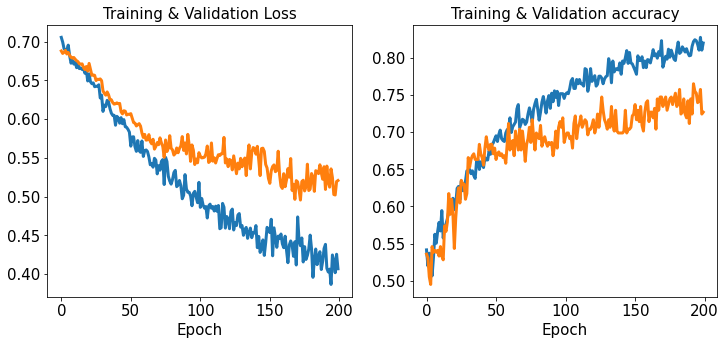

In [436]:
import matplotlib.pyplot as plt

hist=history.history

fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.plot(hist['loss'],lw=3)
ax.plot(hist['val_loss'],lw=3)
ax.set_title('Training & Validation Loss',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax=fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'],lw=3)
ax.plot(hist['val_accuracy'],lw=3)
ax.set_title('Training & Validation accuracy',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
plt.show()




In [32]:
!pip install shap

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394130 sha256=fa7a3695c4152743202e7de8bd95b7d76cec14ad3ea03f3ef255b7369251cec7
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [437]:
import shap

explainer = shap.DeepExplainer(model, np.array(X_train_new))

In [438]:
shap_values  = explainer.shap_values(np.array(X_test_new))

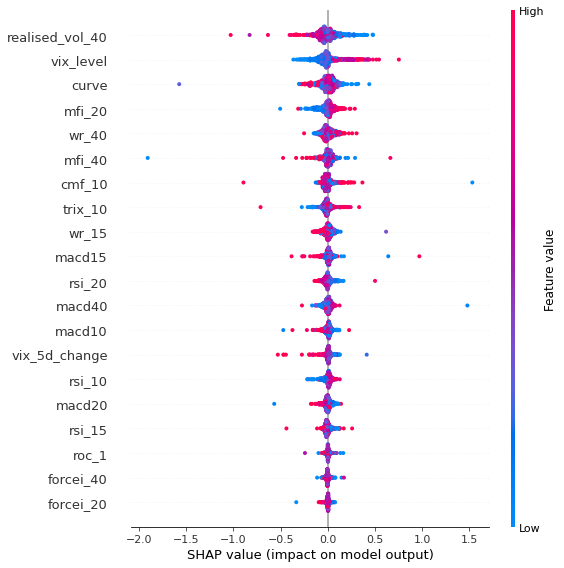

In [439]:
shap.summary_plot(shap_values[1], X_test_new)

In [440]:
pred=model.predict(X_test_new)
pred.argmax(axis=1)

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,

In [441]:
from sklearn.metrics import classification_report, confusion_matrix

cm=confusion_matrix(test_labels, pred.argmax(axis=1))

Confusion Matrix


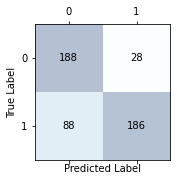

In [442]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [443]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('Recall: %.3f' % recall_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('F1: %.3f' % f1_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

Precision: 0.869
Recall: 0.679
F1: 0.762


In [444]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
import xgboost as xgb
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

In [445]:
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic'))
])

In [446]:
search_space = [
  {
    'clf__n_estimators': [200],
    'clf__learning_rate': [0.05, 0.5, 0.1],
    'clf__max_depth': range(3, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [mutual_info_classif,f_classif],
    'fs__k': [30,40],
  }
]

In [447]:
kfold = KFold(n_splits=4, shuffle=True, random_state=42)

In [448]:
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

In [449]:
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

In [450]:
model = grid.fit(normed_train_data, train_labels)

Fitting 4 folds for each of 504 candidates, totalling 2016 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 2016 out of 2016 | elapsed: 20.0min finished


In [451]:
import pickle

# Dictionary of best parameters
best_pars = grid.best_params_
# Best XGB model that was found based on the metric score you specify
best_model = grid.best_estimator_
# Save model
pickle.dump(grid.best_estimator_, open('gdrive/My Drive/SS_AITrader/'+stock+'/xgb_'+stock+'_log_reg.pickle', "wb"))

In [452]:
predict = model.predict(normed_test_data)
print('Best AUC Score: {}'.format(model.best_score_))
print('Accuracy: {}'.format(accuracy_score(test_labels, predict)))
cm=confusion_matrix(test_labels,predict)

Best AUC Score: 0.9064932269501688
Accuracy: 0.826530612244898


Confusion Matrix


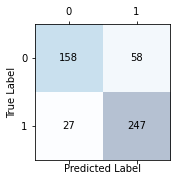

In [453]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [454]:
print(model.best_params_)

{'clf__colsample_bytree': 0.2, 'clf__gamma': 0.1, 'clf__learning_rate': 0.1, 'clf__max_depth': 9, 'clf__n_estimators': 200, 'fs__k': 40, 'fs__score_func': <function mutual_info_classif at 0x7f9d435a61e0>}


In [455]:
k=40
select_k_best = SelectKBest(mutual_info_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)

list_features = list(normed_train_data.columns)
feat_idx = []
for c in selected_features_mic:
      feat_idx.append(list_features.index(c))

feat_idx = sorted(feat_idx)
X_train_new=normed_train_data.iloc[:, feat_idx]
X_test_new=normed_test_data.iloc[:, feat_idx]




In [456]:
model_opt = xgb.XGBClassifier(max_depth=9,
                        objective='binary:logistic',
                        n_estimators=200,
                        learning_rate = 0.1,
                        colsample_bytree= 0.2,
                        gamma= 0.1)
eval_set = [(X_train_new, train_labels), (X_test_new, test_labels)]
model_opt.fit(X_train_new, train_labels, early_stopping_rounds=15, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.263775	validation_0-logloss:0.665437	validation_1-error:0.444898	validation_1-logloss:0.684962
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-error:0.220408	validation_0-logloss:0.645777	validation_1-error:0.406122	validation_1-logloss:0.678383
[2]	validation_0-error:0.168367	validation_0-logloss:0.622259	validation_1-error:0.404082	validation_1-logloss:0.671451
[3]	validation_0-error:0.156633	validation_0-logloss:0.606577	validation_1-error:0.393878	validation_1-logloss:0.665787
[4]	validation_0-error:0.144898	validation_0-logloss:0.587274	validation_1-error:0.373469	validation_1-logloss:0.655825
[5]	validation_0-error:0.116327	validation_0-logloss:0.566592	validation_1-error:0.35102	validation_1-logloss:0.645679
[6]	validation_0-error:0.107653	validation_0-logloss:0.555681	validation_1-error:0.34898	validation_1-logloss:0.6429

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [457]:

# make predictions for test data
y_pred = model_opt.predict(X_test_new)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.88%


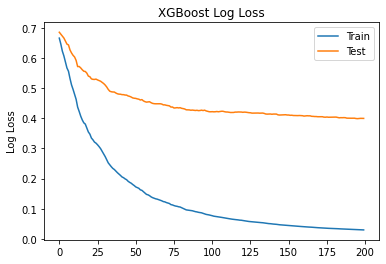

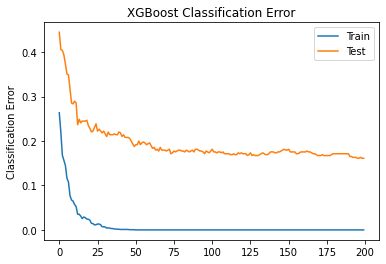

In [458]:
from matplotlib import pyplot

results = model_opt.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [459]:
shap_values = shap.TreeExplainer(model_opt).shap_values(X_test_new) 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


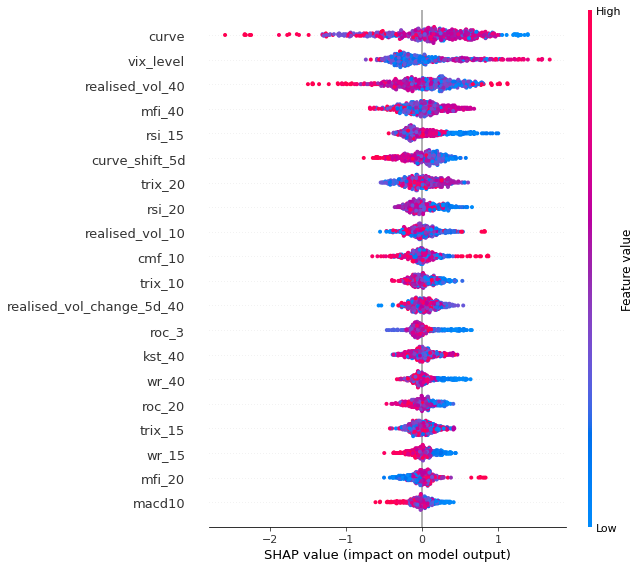

In [460]:
shap.summary_plot(shap_values, X_test_new)

In [461]:
predict = model_opt.predict(X_test_new)

cm=confusion_matrix(test_labels,predict)

Confusion Matrix


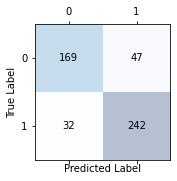

In [462]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()